In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders, variance_based_empath_cleaning, censor_swear_words, plot_temporal_shifts, plot_temporal_shifts_bw
from classes.stats import BootstrapEvaluator
from classes.model_pipeline import OptimalClassificationPipeline, OptimalRegressionPipeline

import warnings
from empath import Empath
from scipy.stats import f_oneway

from sklearn.linear_model import LinearRegression

warnings.simplefilter('ignore')
load_dotenv();

In [3]:
ROOT_PATH = os.path.realpath(os.path.abspath(""))

# Loading the data

In [4]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count', 'noun_ratio',
       'verb_ratio', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density',  'linguistic_uniqueness', 'flesch_reading_ease', 
       'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'vader_compound', 'sentiment_variability']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [6]:
empath_features = variance_based_empath_cleaning(df)

INFO: Total empath features: 194
INFO: Low-variance features to remove: 175


In [7]:
df.explicit = df.explicit.astype(int)

# Identification of features affected by the decade in which they were released

In [8]:
features = [
     'popularity',
     'explicit',
     'duration_ms',
     'danceability',
     'energy',
     'loudness',
     'speechiness',
     'acousticness',
     'instrumentalness',
     'valence',
     'tempo',
     'lexical_richness',
     'semantic_depth',
     'syntactic_complexity',
     'rhyme_density',
     'linguistic_uniqueness',
     'flesch_reading_ease',
     'gunning_fog',
     'dale_chall',
     'type_token_ratio',
     'sentiment_polarity',
     'sentiment_subjectivity',
     'vader_compound',
     'sentiment_variability'
]

df['decade'] = (df['album_release_year'] // 10) * 10

time_data = df.groupby('decade')[features].mean().reset_index()

results = {}
for feature in features:
    X = time_data[['decade']]
    y = time_data[feature]
    
    model = LinearRegression()
    model.fit(X, y)
    
    results[feature] = {
        'R²': model.score(X, y),
        'Trend Coefficient': model.coef_[0]
    }

trend_results = pd.DataFrame(results).T
trend_results.index.name = 'Feature'
trend_results = trend_results.sort_values('R²', ascending=False)

anova_results = {}
for feature in features:
    groups = [group[feature].values for _, group in df.groupby('decade')]
    
    f_stat, p_value = f_oneway(*groups)
    anova_results[feature] = {
        'F-Statistic': f_stat,
        'p-Value': p_value
    }

anova_results_df = pd.DataFrame(anova_results).T
anova_results_df.index.name = 'Feature'
anova_results_df = anova_results_df.sort_values('p-Value', ascending=True)

combined_results = trend_results.merge(anova_results_df, left_index=True, right_index=True)

significant_features = combined_results[combined_results['p-Value'] < 0.05]
print("Significant Features Across Decades (p < 0.05):")
significant_features

Significant Features Across Decades (p < 0.05):


,R²,Trend Coefficient,F-Statistic,p-Value
Feature,,,,
explicit,0.909073,0.006645,76.023316,3.948376e-103
valence,0.906611,-0.003028,45.487845,4.319430e-62
syntactic_complexity,0.905622,0.519760,3.188473,2.285480e-03
popularity,0.893476,0.276672,61.320459,1.308784e-83
vader_compound,0.880113,-0.007787,11.830054,5.556410e-15
sentiment_polarity,0.853502,-0.001479,8.135521,7.366039e-10
loudness,0.833296,0.068308,139.657491,1.162553e-182
rhyme_density,0.824603,-0.000094,18.454532,2.642475e-24
danceability,0.814174,0.001072,7.099057,1.903763e-08


In [9]:
significant_features = significant_features[:7]
significant_features

,R²,Trend Coefficient,F-Statistic,p-Value
Feature,,,,
explicit,0.909073,0.006645,76.023316,3.948376e-103
valence,0.906611,-0.003028,45.487845,4.319430e-62
syntactic_complexity,0.905622,0.519760,3.188473,2.285480e-03
popularity,0.893476,0.276672,61.320459,1.308784e-83
vader_compound,0.880113,-0.007787,11.830054,5.556410e-15
sentiment_polarity,0.853502,-0.001479,8.135521,7.366039e-10
loudness,0.833296,0.068308,139.657491,1.162553e-182


In [10]:
print(significant_features.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & R² & Trend Coefficient & F-Statistic & p-Value \\
Feature &  &  &  &  \\
\midrule
explicit & 0.909073 & 0.006645 & 76.023316 & 0.000000 \\
valence & 0.906611 & -0.003028 & 45.487845 & 0.000000 \\
syntactic_complexity & 0.905622 & 0.519760 & 3.188473 & 0.002285 \\
popularity & 0.893476 & 0.276672 & 61.320459 & 0.000000 \\
vader_compound & 0.880113 & -0.007787 & 11.830054 & 0.000000 \\
sentiment_polarity & 0.853502 & -0.001479 & 8.135521 & 0.000000 \\
loudness & 0.833296 & 0.068308 & 139.657491 & 0.000000 \\
\bottomrule
\end{tabular}



In [11]:
features = trend_results.index
features

Index(['explicit', 'valence', 'syntactic_complexity', 'popularity',
       'vader_compound', 'sentiment_polarity', 'loudness', 'rhyme_density',
       'danceability', 'speechiness', 'dale_chall', 'flesch_reading_ease',
       'gunning_fog', 'lexical_richness', 'type_token_ratio', 'energy',
       'sentiment_subjectivity', 'acousticness', 'duration_ms',
       'semantic_depth', 'tempo', 'sentiment_variability',
       'linguistic_uniqueness', 'instrumentalness'],
      dtype='object', name='Feature')

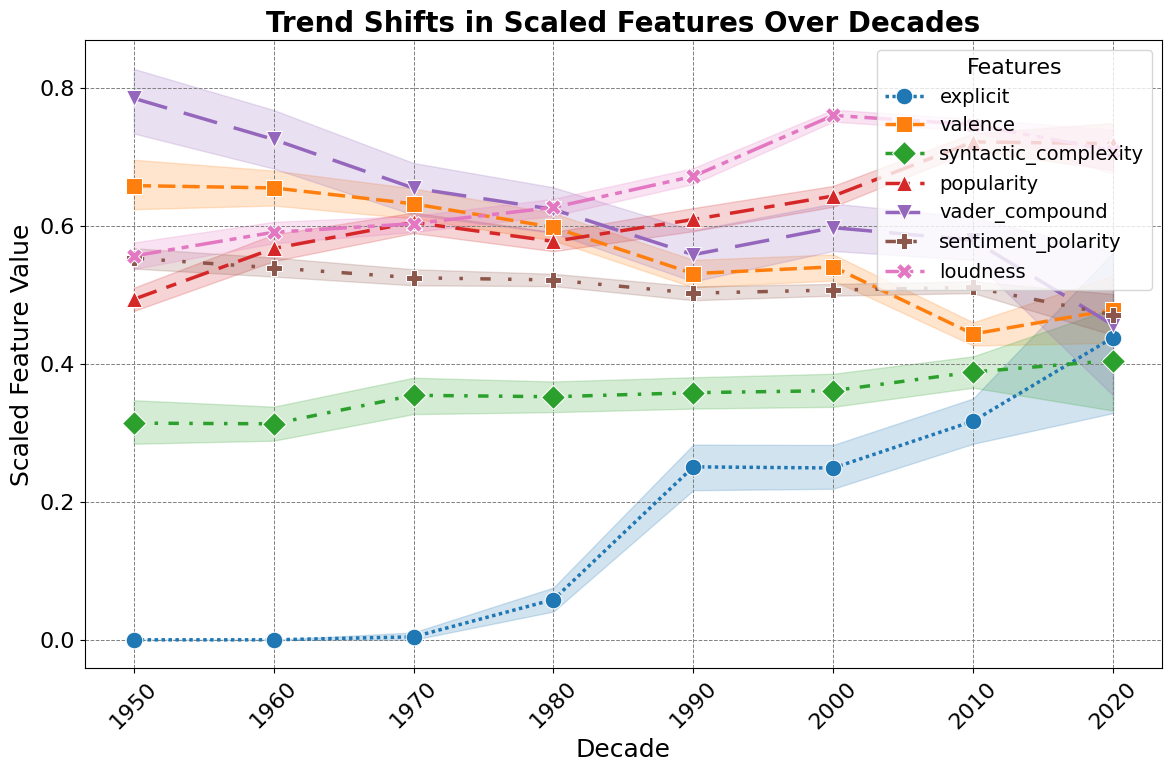

In [13]:
fig = plot_temporal_shifts_bw(df, features[:7])
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'temporal_trends_for_paper.png'))
fig

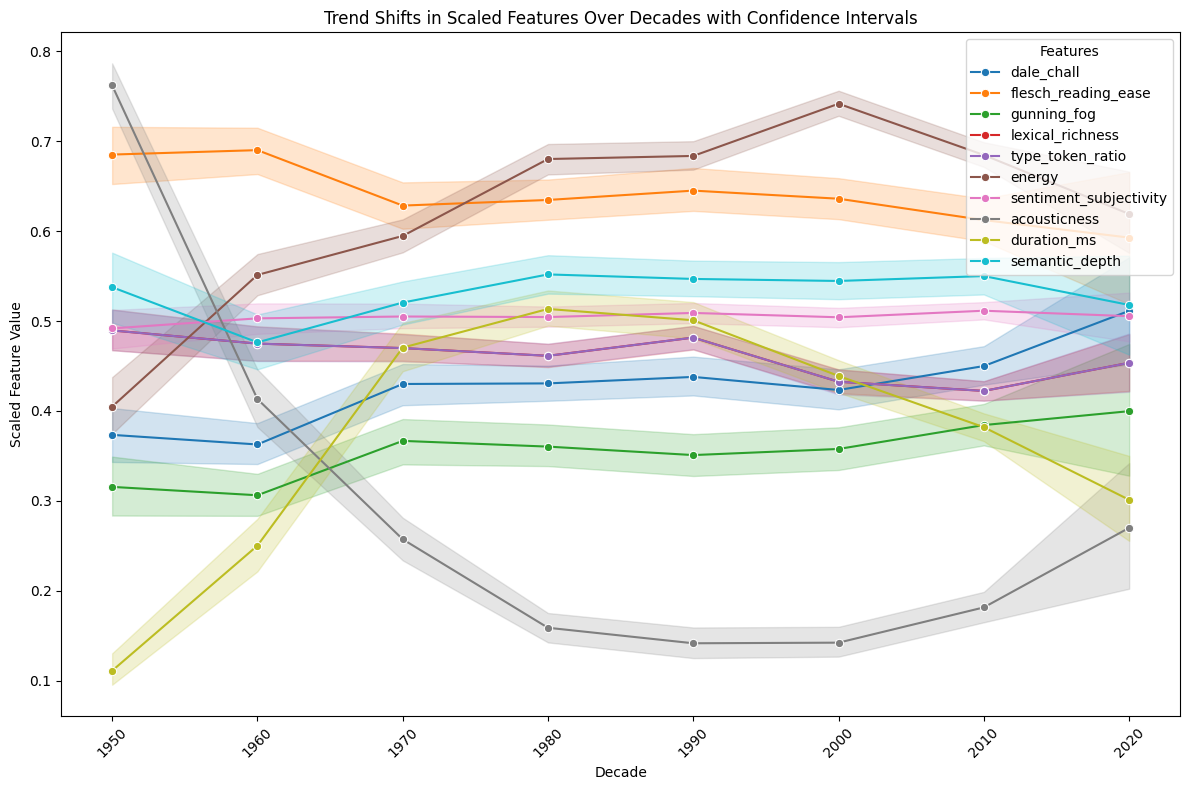

In [47]:
fig = plot_temporal_shifts(df, features[10:20])
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'temporal_trends_2.png'))
fig

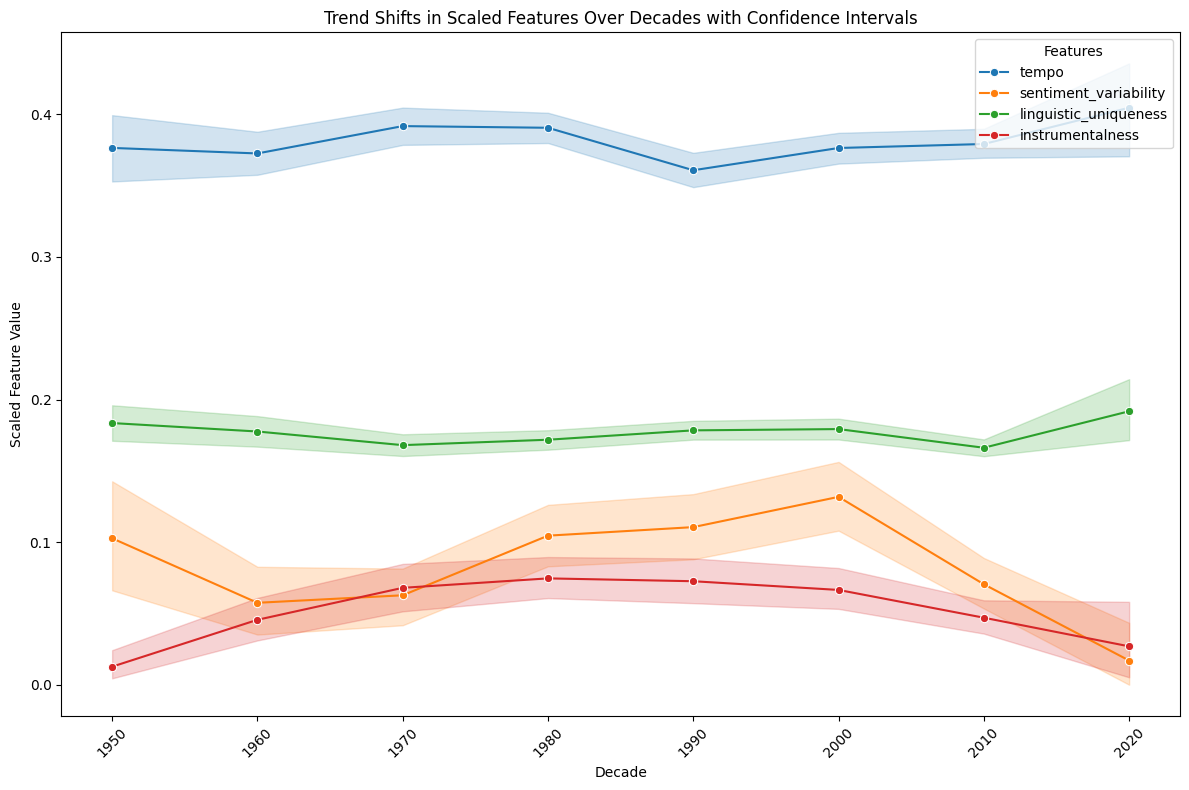

In [48]:
fig = plot_temporal_shifts(df, features[20:])
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'temporal_trends_3.png'))
fig